In [13]:
import time
import psutil
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
from cryptography.hazmat.backends import default_backend
from cryptography.hazmat.primitives.padding import PKCS7
from prettytable import PrettyTable
import csv
import os

# Generate deterministic datasets for testing
def generate_deterministic_datasets(size_mb):
    size_bytes = size_mb * 1024 * 1024  # Convert MB to Bytes
    return b"a" * size_bytes

# Test encryption and decryption
def test_symmetric_algorithm(algorithm, key, iv, data_size_mb, iterations):
    data = generate_deterministic_datasets(data_size_mb)

    # Measure encryption speed
    encryption_time_total = 0
    for _ in range(iterations):
        # Create new instances for each iteration
        cipher = Cipher(algorithm, modes.CBC(iv), backend=default_backend())
        padder = PKCS7(algorithm.block_size).padder()
        encryptor = cipher.encryptor()
        padded_data = padder.update(data) + padder.finalize()

        start_time = time.time()
        encrypted_data = encryptor.update(padded_data) + encryptor.finalize()
        encryption_time_total += (time.time() - start_time)

    encryption_time = encryption_time_total / iterations
    encryption_speed = data_size_mb / encryption_time  # MB per second

    # Measure decryption speed
    decryption_time_total = 0
    for _ in range(iterations):
        # Create new instances for each iteration
        cipher = Cipher(algorithm, modes.CBC(iv), backend=default_backend())
        unpadder = PKCS7(algorithm.block_size).unpadder()
        decryptor = cipher.decryptor()

        start_time = time.time()
        decrypted_data = unpadder.update(decryptor.update(encrypted_data) + decryptor.finalize()) + unpadder.finalize()
        decryption_time_total += (time.time() - start_time)

    decryption_time = decryption_time_total / iterations
    decryption_speed = data_size_mb / decryption_time  # MB per second

    # Measure resource consumption
    process = psutil.Process(os.getpid())
    avg_cpu_usage = psutil.cpu_percent(interval=0.1)

    return encryption_time, encryption_speed, decryption_time, decryption_speed, avg_cpu_usage

# Main function
def main():
    algorithms_to_test = {
        "AES": {"algorithm": algorithms.AES, "key_size": 32, "block_size": 128},
        "3DES": {"algorithm": algorithms.TripleDES, "key_size": 24, "block_size": 64},
        "Blowfish": {"algorithm": algorithms.Blowfish, "key_size": 16, "block_size": 64},
    }
    data_sizes_mb = [1, 2, 4, 8, 16, 32]  # Test datasets
    iterations = 10

    # Prepare PrettyTable
    table = PrettyTable()
    table.field_names = [
        "Algorithm",
        "Data Size (MB)",
        "Encryption Time (ms)",
        "Encryption Speed (MBps)",
        "Decryption Time (ms)",
        "Decryption Speed (MBps)",
        "CPU Usage (%)",
    ]

    # Open CSV file for writing
    csv_file = "symmetric_algorithm_results.csv"
    with open(csv_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([
            "Algorithm", "Data Size (MB)", "Encryption Time (ms)", "Encryption Speed (MBps)",
            "Decryption Time (ms)", "Decryption Speed (MBps)", "CPU Usage (%)"
        ])

        for algo_name, params in algorithms_to_test.items():
            key = os.urandom(params["key_size"])
            iv = os.urandom(params["block_size"] // 8)
            algorithm = params["algorithm"](key)
            for size_mb in data_sizes_mb:
                encryption_time, encryption_speed, decryption_time, decryption_speed, avg_cpu_usage = test_symmetric_algorithm(
                    algorithm, key, iv, size_mb, iterations
                )
                encryption_time_ms = encryption_time * 1000
                decryption_time_ms = decryption_time * 1000

                # Add results to table
                table.add_row([
                    algo_name, size_mb, f"{encryption_time_ms:.3f}", f"{encryption_speed:.3f}",
                    f"{decryption_time_ms:.3f}", f"{decryption_speed:.3f}", f"{avg_cpu_usage:.2f}"
                ])
                writer.writerow([
                    algo_name, size_mb, encryption_time_ms, encryption_speed,
                    decryption_time_ms, decryption_speed, avg_cpu_usage
                ])

    # Print results to console
    print(table)
    print(f"Results written to {csv_file}")


if __name__ == "__main__":
    main()


C:\Users\emsig\AppData\Local\Temp\ipykernel_12092\4260839643.py:60: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "3DES": {"algorithm": algorithms.TripleDES, "key_size": 24, "block_size": 64},
C:\Users\emsig\AppData\Local\Temp\ipykernel_12092\4260839643.py:61: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "Blowfish": {"algorithm": algorithms.Blowfish, "key_size": 16, "block_size": 64},


+-----------+----------------+----------------------+-------------------------+----------------------+-------------------------+---------------+
| Algorithm | Data Size (MB) | Encryption Time (ms) | Encryption Speed (MBps) | Decryption Time (ms) | Decryption Speed (MBps) | CPU Usage (%) |
+-----------+----------------+----------------------+-------------------------+----------------------+-------------------------+---------------+
|    AES    |       1        |        1.138         |         878.756         |        0.764         |         1309.288        |      0.80     |
|    AES    |       2        |        2.049         |         976.225         |        1.275         |         1568.052        |      0.80     |
|    AES    |       4        |        3.922         |         1019.854        |        2.561         |         1561.863        |      2.30     |
|    AES    |       8        |        8.564         |         934.099         |        5.988         |         1335.968        |  

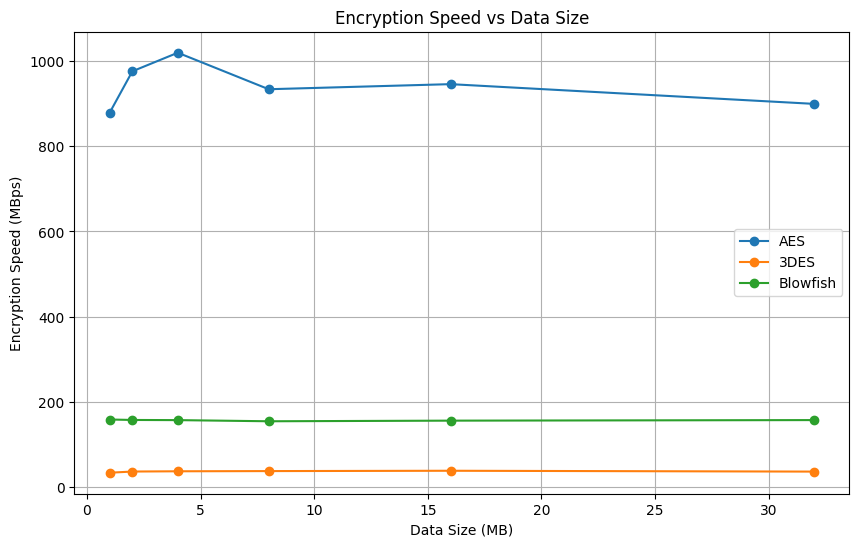

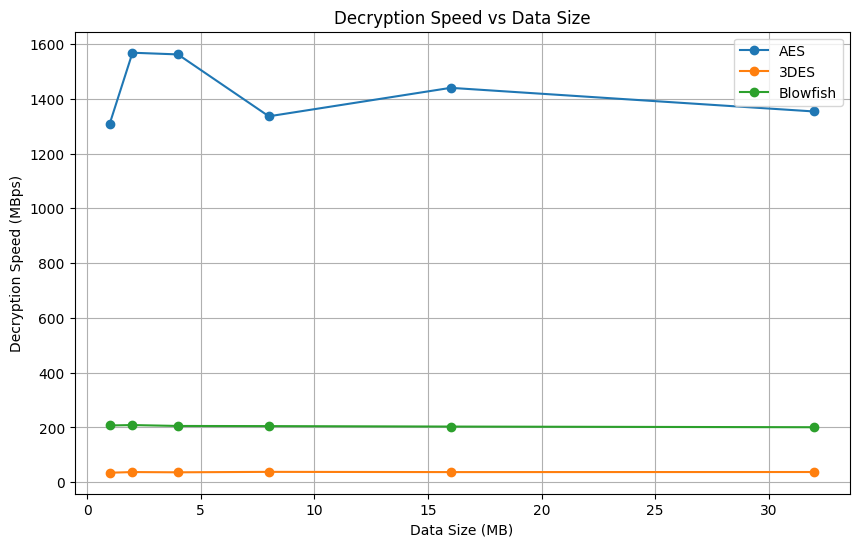

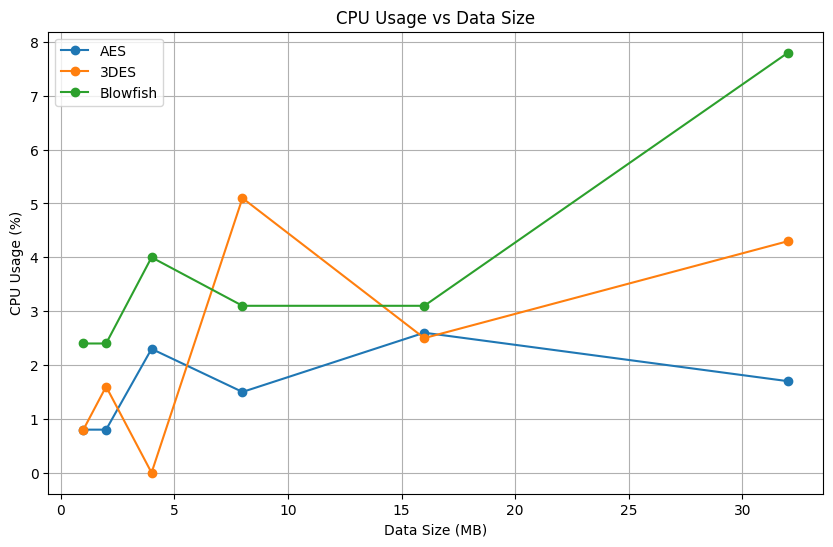

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file
csv_file = "symmetric_algorithm_results.csv"
data = pd.read_csv(csv_file)

# Function to plot a specific metric
def plot_metric(metric, title, ylabel):
    plt.figure(figsize=(10, 6))
    for algo in data["Algorithm"].unique():
        subset = data[data["Algorithm"] == algo]
        plt.plot(subset["Data Size (MB)"], subset[metric], marker='o', label=algo)
    
    plt.title(title)
    plt.xlabel("Data Size (MB)")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot encryption time
# plot_metric("Encryption Time (ms)", "Encryption Time vs Data Size", "Encryption Time (ms)")

# Plot encryption speed
plot_metric("Encryption Speed (MBps)", "Encryption Speed vs Data Size", "Encryption Speed (MBps)")

# Plot decryption time
# plot_metric("Decryption Time (ms)", "Decryption Time vs Data Size", "Decryption Time (ms)")

# Plot decryption speed
plot_metric("Decryption Speed (MBps)", "Decryption Speed vs Data Size", "Decryption Speed (MBps)")

# Plot CPU usage
plot_metric("CPU Usage (%)", "CPU Usage vs Data Size", "CPU Usage (%)")
